In [1]:
import pandas as pd
import torch
import sklearn
import numpy as np

import transformers

c:\Users\robin\anaconda3\envs\dnabert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

In [3]:
modelpath = "zhihan1996/DNABERT-2-117M"
df = pd.read_csv("./sample_data/esp_decoded.csv")

print(df.info())

print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56888 entries, 0 to 56887
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seq     56888 non-null  object 
 1   y       56888 non-null  float64
dtypes: float64(1), object(1)
memory usage: 889.0+ KB
None
                     seq         y
0  AAAAAAAAACTCCAAAACCCT  0.093147
1  AAAAAACAACAAGAAGCACAA  0.064951
2  AAAAAACACAAGCAAGACCGT  0.061797
3  AAAAAACAGATGCCACCTGTG  0.057246
4  AAAAAACCCGTAGATAGCCTC  0.067596


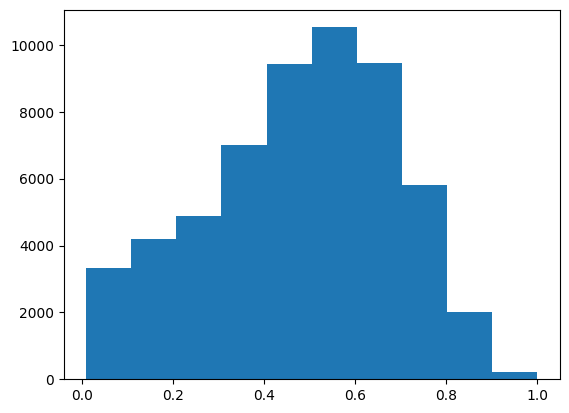

In [4]:
import matplotlib.pyplot as plt

#plot label distribution
plt.hist(df['y'])
plt.show()

In [5]:
import datasets

#turn df into a dataset
raw_dataset = datasets.Dataset.from_pandas(df)

In [6]:
#raw_dataset = raw_dataset.select(range(int(1300 * 1.2)))

print(raw_dataset)

Dataset({
    features: ['seq', 'y'],
    num_rows: 1560
})


In [7]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
        modelpath,
        
        model_max_length=100,
        padding_side="right",
        use_fast=True,
        trust_remote_code=True,
    )

In [8]:
from transformers import DataCollatorWithPadding

def tokenize_function(example):
    return tokenizer(example["seq"], truncation=True)

tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format("torch")

#print(output)
print(tokenized_dataset)

Map: 100%|██████████| 1560/1560 [00:00<00:00, 33199.12 examples/s]

Dataset({
    features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1560
})


In [9]:
#split into train and validation set
tokenized_datasets = tokenized_dataset.train_test_split(test_size=0.2)

In [10]:
print(tokenized_datasets)

tokenized_datasets = tokenized_datasets.remove_columns(["seq"])
tokenized_datasets = tokenized_datasets.rename_column("y", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names


DatasetDict({
    train: Dataset({
        features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1248
    })
    test: Dataset({
        features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 312
    })
})


['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [11]:
from torch.utils.data import DataLoader

batch_size = 128

print(tokenizer.pad_token_id)
print(tokenizer.model_max_length)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding="longest", max_length=tokenizer.model_max_length)




3
100


In [12]:
# train_dataloader = DataLoader(
#     tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
# )
# eval_dataloader = DataLoader(
#     tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
# )

In [13]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    modelpath,
    cache_dir=None,
    num_labels=1,
    trust_remote_code=True,
    ignore_mismatched_sizes=True
)

model.cuda()

C:\Users\robin/.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\25abaf0bd247444fcfa837109f12088114898d98\bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_feat

In [14]:
# for batch in train_dataloader:
#     print(batch['labels'][0])
#     break
# print({k: v.shape for k, v in batch.items()})

In [15]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    logits = logits[0]

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

In [16]:
from transformers import Trainer, TrainingArguments

# Specifiy the arguments for the trainer  
training_args = TrainingArguments(
    output_dir ='./results',          
    num_train_epochs = 3,     
    per_device_train_batch_size = 128,   
    per_device_eval_batch_size = 32,   
    weight_decay = 0.01,               
    learning_rate = 3e-5,
    logging_dir = './logs',
    logging_steps = 10,        
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
) 

# Call the Trainer
trainer = Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = tokenized_datasets["train"],         
    eval_dataset = tokenized_datasets["test"],          
    compute_metrics = compute_metrics,
    data_collator = data_collator, 
)

# Train the model
trainer.train()

# Call the summary
trainer.evaluate()

c:\Users\robin\anaconda3\envs\dnabert\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 10/30 [00:49<01:39,  4.97s/it]

{'loss': 0.0409, 'learning_rate': 1.9999999999999998e-05, 'epoch': 1.0}


                                               
 33%|███▎      | 10/30 [00:49<01:39,  4.97s/it]

{'eval_loss': 0.02351677045226097, 'eval_mse': 0.02351677045226097, 'eval_rmse': 0.1533517837524414, 'eval_mae': 0.12378602474927902, 'eval_r2': 0.014300998896091266, 'eval_runtime': 0.7307, 'eval_samples_per_second': 426.977, 'eval_steps_per_second': 13.685, 'epoch': 1.0}


 43%|████▎     | 13/30 [01:08<01:37,  5.76s/it]

KeyboardInterrupt: 

In [ ]:

from tqdm.auto import tqdm

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    modelpath,
    cache_dir=None,
    num_labels=1,
    trust_remote_code=True,
)

model.cuda()

#metric = evaluate.load("accuracy")
#model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}

    labels = batch["labels"].reshape(-1, 1)

    with torch.no_grad():
        outputs = model(**batch)
    
    #calculate metrics

    logits = outputs["logits"]
    
    #use cpu to calculate metrics
    logits = logits.cpu()
    labels = labels.cpu()

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    #smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)
    print(logits[:5])
    print(labels[:5])

    print("mse: ", mse, " rmse: ", rmse, " mae: ", mae, " r2: ", r2)
    break


#metric.compute()

#trained

# tensor([[0.5489],
#         [0.3944],
#         [0.7925],
#         [0.4906],
#         [0.5423]])
# tensor([[0.6034],
#         [0.5854],
#         [0.7205],
#         [0.1395],
#         [0.5100]])
# mse:  0.031777926  rmse:  0.17826363  mae:  0.13696145  r2:  0.25551206762590795

#untrained

# tensor([[-0.0495],
#         [ 0.0050],
#         [ 0.0346],
#         [ 0.1536],
#         [-0.0072]])
# tensor([[0.6034],
#         [0.5854],
#         [0.7205],
#         [0.1395],
#         [0.5100]])
# mse:  0.2381744  rmse:  0.48803115  mae:  0.440737  r2:  -4.579909511011868

C:\Users\robin/.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\1d020b803b871a976f5f3d5565f0eac8f2c7bb81\bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassi

tensor([[-0.0495],
        [ 0.0050],
        [ 0.0346],
        [ 0.1536],
        [-0.0072]])
tensor([[0.6034],
        [0.5854],
        [0.7205],
        [0.1395],
        [0.5100]])
mse:  0.2381744  rmse:  0.48803115  mae:  0.440737  r2:  -4.579909511011868
